[#########################    40%                              ] ETA: 0:00:01performing action UNPLUG_KETTLE with KETTLE
[############################ 56% #                            ] ETA: 0:00:01performing action UNPLUG_KETTLE with KETTLE
[############################ 70% ##########                   ] ETA: 0:00:01performing action PUT_KETTLE_UNDER_TAP with KETTLE
[############################ 85% ####################         ] ETA: 0:00:01performing action PUT_KETTLE_UNDER_TAP with KETTLE
Simulation finished in 0:00:02.                                                 


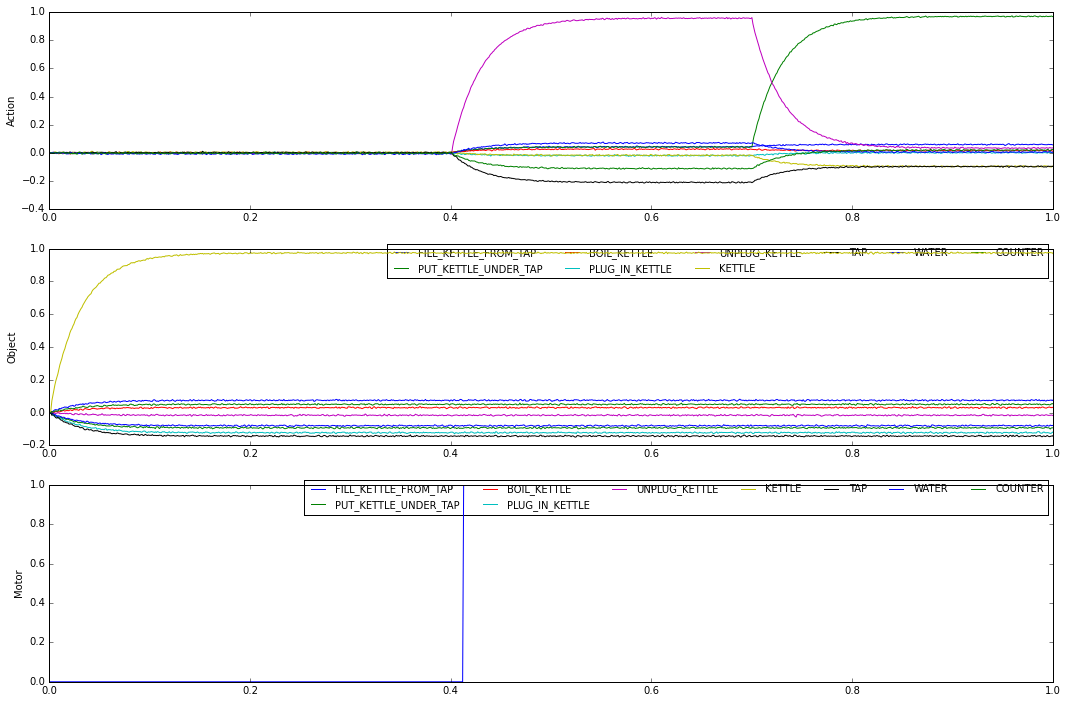

In [2]:
import numpy as np
import nengo
import nengo.spa as spa
import world
import kitchen
import nodes

import matplotlib.pyplot as plt
%matplotlib inline

D = 128

test_world = kitchen.get_kitchen()

objects = ['KETTLE', 'TAP', 'WATER', 'COUNTER']
action_set = ['FILL_KETTLE_FROM_TAP', 'PUT_KETTLE_UNDER_TAP', 'BOIL_KETTLE', 'PLUG_IN_KETTLE','UNPLUG_KETTLE']

motor_vocab = spa.Vocabulary(D)
    
for action in action_set:
    motor_vocab.parse(action)
    
for obj in objects:
    motor_vocab.parse(obj)

motor_sys = nodes.MotorSystem(motor_vocab, test_world)

with spa.SPA() as model:
    model.action = spa.Buffer(dimensions=D, vocab=motor_vocab)
    model.obj = spa.Buffer(dimensions=D, vocab=motor_vocab)
    model.motor = nengo.Node(motor_sys, size_in=2*D, size_out=1)
    
    def set_action(t):
        if 0.4 < t < 0.7:
            return 'UNPLUG_KETTLE'
        if 0.7 < t < 1:
            return 'PUT_KETTLE_UNDER_TAP'
        else: return '0'

    def set_obj(t):
        return 'KETTLE'
    
    model.inp = spa.Input(action=set_action, obj=set_obj)
    
    nengo.Connection(model.action.state.output, model.motor[D:])
    nengo.Connection(model.obj.state.output, model.motor[:D])
    
    act_probe = nengo.Probe(model.action.state.output, synapse=0.03)
    obj_probe = nengo.Probe(model.obj.state.output, synapse=0.03)
    mot_probe = nengo.Probe(model.motor)
    
def plot(sim):
    fig = plt.figure(figsize=(18,12))

    p1 = fig.add_subplot(3,1,1)
    p1.plot(sim.trange(), model.similarity(sim.data, act_probe))
    p1.legend(model.get_output_vocab('action').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=6)
    p1.set_ylabel('Action')

    p2 = fig.add_subplot(3,1,2)
    p2.plot(sim.trange(), model.similarity(sim.data, obj_probe))
    p2.legend(model.get_output_vocab('obj').keys, fontsize='medium', bbox_to_anchor=(1, -0.15), ncol=7)
    p2.set_ylabel('Object')

    p3 = fig.add_subplot(3,1,3)
    p3.plot(sim.trange(), sim.data[mot_probe])
    p3.set_ylabel('Motor')
    
sim = nengo.Simulator(model)
sim.reset()
sim.run(1)

plot(sim)

In [3]:
test_world.print_state()

WATER
{'TEMPERATURE': 'COLD'}
------------------
KETTLE
{'PLUGGED': 'UNPLUGGED'}
UNDER-TAP
------------------
TAP
{'OFFON': 'OFF'}
------------------
COUNTER
{}
------------------
